# マルチモーダル・マーケティング（ダミーデータ） + SHAP 解析

目的：マーケティング文脈で、ダミーの製品データ（画像・レビュー文章・数値特徴）から 購入意向（buy=1/0） を予測する二値分類モデルを学習します。

モダリティ：

1. 画像（ブランド名入りのシンプルな製品風画像）

2. テキスト（レビュー文テンプレート：great/good/average/poor/terrible の感情語を含む）

3. 表形式（数値）：price（価格）、rating（評価）、discount（割引率）

モデル：PyTorch で レイト・フュージョン（late fusion） 構成。
画像用の小型 CNN、テキスト用 MLP（Bag-of-Words ベクトル入力）、数値用 MLP の3つのエンコーダ出力を結合して最終分類器へ入力します。

説明可能性：SHAP（KernelExplainer） を使って、表形式特徴（price/rating/discount） が予測（buy=1）に与える寄与度を可視化します。
※マルチモーダルのうち、SHAP 解析では 画像とテキストをゼロ固定して、数値特徴の寄与にフォーカスします。


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/test/

Mounted at /content/drive
/content/drive/MyDrive/test


In [ ]:

# @title Install dependencies (Colab)
!pip -q install numpy pandas scikit-learn matplotlib seaborn pillow torch torchvision torchaudio   transformers==4.44.2 datasets==3.0.1 pytorch-lightning==2.4.0 accelerate==1.0.0 shap

import os, random, math, json, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Fix seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 45.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.


## 1. ダミーデータ生成（画像・テキスト・数値）
- 画像：ブランド名付きの単純な矩形画像
- テキスト：レビュー文テンプレート（感情を混在）
- 数値：price / rating / discount
- ラベル：直観的なスコア則で `buy` を付与


In [ ]:

# @title Generate synthetic images & data
N = 2000
IMG_SIZE = 128
IMG_DIR = 'images'
os.makedirs(IMG_DIR, exist_ok=True)

brands = ['Alpha', 'Bravo', 'Citrus', 'Delta', 'Echo']
categories = ['Electronics', 'Beauty', 'Home', 'Fashion', 'Sports']
sentiments = ['great', 'good', 'average', 'poor', 'terrible']

# Helper to create a simple synthetic product image

def make_image(color, text, path):
  img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color=color)
  draw = ImageDraw.Draw(img)
  # Draw a product square
  margin = 16
  draw.rectangle([margin, margin, IMG_SIZE - margin, IMG_SIZE - margin], outline=(255,255,255), width=3)
  # Draw a simple stripe indicating discount
  draw.rectangle([0, IMG_SIZE-20, IMG_SIZE, IMG_SIZE], fill=(255,255,255))
  # Text (brand)
  try:
    draw.text((20, 20), text, fill=(255,255,255))
  except Exception:
    pass
  img.save(path)
  return path

rows = []

for i in range(N):
  brand = random.choice(brands)
  category = random.choice(categories)
  base_color = tuple(np.random.randint(0, 256, size=3).tolist())
  price = round(np.random.uniform(9, 299), 2)
  rating = round(np.clip(np.random.normal(4.0, 1.0), 1.0, 5.0), 1)
  discount = round(np.clip(np.random.normal(0.2, 0.15), 0.0, 0.8), 2)  # fraction
  sentiment = random.choices(sentiments, weights=[0.30,0.25,0.20,0.15,0.10])[0]
  # Review text template
  review = f"I think this {brand} {category.lower()} is {sentiment}. Price feels fair. Would consider buying again."

  # Simple label rule: higher rating & discount, lower price, positive sentiment -> buy
  sent_score = {'great': 2, 'good': 1, 'average': 0, 'poor': -1, 'terrible': -2}[sentiment]
  score = (rating - 3.0) + (0.5 if discount > 0.25 else 0) + (1.0 if price < 80 else -0.5) + sent_score
  buy = 1 if score > 0.3 else 0

  img_path = os.path.join(IMG_DIR, f"img_{i}.png")
  make_image(base_color, brand, img_path)

  rows.append({
      'id': i,
      'brand': brand,
      'category': category,
      'price': price,
      'rating': rating,
      'discount': discount,
      'review': review,
      'image_path': img_path,
      'buy': buy
  })


df = pd.DataFrame(rows)
df.head()


,id,brand,category,price,rating,discount,review,image_path,buy
0,0,Alpha,Electronics,62.20,4.5,0.41,I think this Alpha electronics is average. Pri...,images/img_0.png,1
1,1,Bravo,Beauty,25.84,4.3,0.35,I think this Bravo beauty is great. Price feel...,images/img_1.png,1
2,2,Alpha,Sports,25.36,4.2,0.22,I think this Alpha sports is great. Price feel...,images/img_2.png,1
3,3,Delta,Electronics,62.19,4.2,0.00,I think this Delta electronics is great. Price...,images/img_3.png,1
4,4,Bravo,Beauty,161.18,3.5,0.18,I think this Bravo beauty is good. Price feels...,images/img_4.png,1


## 2. EDA（分布・クラスバランス）

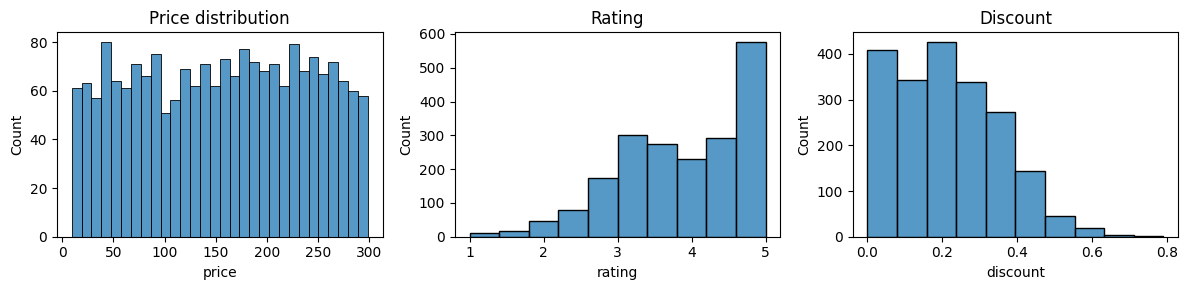

Class balance (buy):
buy
1    1459
0     541
Name: count, dtype: int64


In [ ]:

# Distribution plots
fig, axes = plt.subplots(1,3, figsize=(12,3))
sns.histplot(df['price'], bins=30, ax=axes[0])
axes[0].set_title('Price distribution')
sns.histplot(df['rating'], bins=10, ax=axes[1])
axes[1].set_title('Rating')
sns.histplot(df['discount'], bins=10, ax=axes[2])
axes[2].set_title('Discount')
plt.tight_layout()
plt.show()

print('Class balance (buy):')
print(df['buy'].value_counts())


## 3. 学習用/検証用の分割

In [ ]:

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['buy'], random_state=42)
len(train_df), len(val_df)


(1600, 400)

## 4. テキスト前処理（軽量 BoW）
`CountVectorizer` による Bag-of-Words（最大語彙500）。


In [ ]:

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=500)
vectorizer.fit(train_df['review'].tolist())

def text_to_vec(text):
  v = vectorizer.transform([text]).toarray().astype(np.float32)[0]
  return v

VOCAB_SIZE = len(vectorizer.vocabulary_)
print('Vocab size:', VOCAB_SIZE)


Vocab size: 25


## 5. Dataset/DataLoader（PyTorch）

In [ ]:

img_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

class MarketingMM(Dataset):
  def __init__(self, frame):
    self.frame = frame.reset_index(drop=True)
  def __len__(self):
    return len(self.frame)
  def __getitem__(self, idx):
    row = self.frame.iloc[idx]
    # Image
    img = Image.open(row['image_path']).convert('RGB')
    img = img_transform(img)
    # Text
    text_vec = torch.tensor(text_to_vec(row['review']))
    # Tabular
    tab = torch.tensor([row['price'], row['rating'], row['discount']], dtype=torch.float32)
    label = torch.tensor(row['buy'], dtype=torch.long)
    return img, text_vec, tab, label

train_ds = MarketingMM(train_df)
val_ds = MarketingMM(val_df)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)


## 6. モデル（レイト・フュージョン）
画像CNN／テキストMLP／表MLPの出力を結合して分類。


In [ ]:

class ImgEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(3, 16, 3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
        nn.AdaptiveAvgPool2d((1,1))
    )
    self.out = nn.Linear(64, 64)
  def forward(self, x):
    x = self.conv(x)
    x = x.view(x.size(0), -1)
    return F.relu(self.out(x))

class TextEncoder(nn.Module):
  def __init__(self, vocab_size):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(vocab_size, 256), nn.ReLU(),
        nn.Linear(256, 64), nn.ReLU()
    )
  def forward(self, x):
    return self.net(x)

class TabEncoder(nn.Module):
  def __init__(self, in_dim=3):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(in_dim, 32), nn.ReLU(),
        nn.Linear(32, 32), nn.ReLU()
    )
  def forward(self, x):
    return self.net(x)

class MMClassifier(nn.Module):
  def __init__(self, vocab_size):
    super().__init__()
    self.img_enc = ImgEncoder()
    self.txt_enc = TextEncoder(vocab_size)
    self.tab_enc = TabEncoder(3)
    self.cls = nn.Sequential(
        nn.Linear(64+64+32, 64), nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(64, 2)
    )
  def forward(self, img, txt, tab):
    zi = self.img_enc(img)
    zt = self.txt_enc(txt)
    zb = self.tab_enc(tab)
    z = torch.cat([zi, zt, zb], dim=1)
    return self.cls(z)

model = MMClassifier(VOCAB_SIZE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)


MMClassifier(
  (img_enc): ImgEncoder(
    (conv): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): AdaptiveAvgPool2d(output_size=(1, 1))
    )
    (out): Linear(in_features=64, out_features=64, bias=True)
  )
  (txt_enc): TextEncoder(
    (net): Sequential(
      (0): Linear(in_features=25, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=64, bias=True)
      (3): ReLU()
    )
  )
  (tab_enc): TabEncoder(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
    )
  )
  (cls): Sequential(
    (0): Linear(in_features=160, out_features=64, bias=True)
    (1): ReL

## 7. 学習（5エポック）

In [ ]:

EPOCHS = 5

for epoch in range(1, EPOCHS+1):
  model.train()
  total_loss = 0
  for img, txt, tab, y in train_loader:
    img, txt, tab, y = img.to(device), txt.to(device), tab.to(device), y.to(device)
    optimizer.zero_grad()
    logits = model(img, txt, tab)
    loss = criterion(logits, y)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  # Validation
  model.eval()
  preds, gts = [], []
  with torch.no_grad():
    for img, txt, tab, y in val_loader:
      img, txt, tab = img.to(device), txt.to(device), tab.to(device)
      logits = model(img, txt, tab)
      pred = torch.argmax(logits, dim=1).cpu().numpy()
      preds.extend(pred.tolist())
      gts.extend(y.numpy().tolist())

  acc = (np.array(preds) == np.array(gts)).mean()
  print(f"Epoch {epoch}: loss={total_loss/len(train_loader):.4f}, val_acc={acc:.3f}")


Epoch 1: loss=0.6490, val_acc=0.730
Epoch 2: loss=0.3741, val_acc=0.868
Epoch 3: loss=0.3239, val_acc=0.870
Epoch 4: loss=0.3096, val_acc=0.885
Epoch 5: loss=0.3044, val_acc=0.870


## 8. 評価（classification_report と混同行列）

              precision    recall  f1-score   support

           0      0.952     0.546     0.694       108
           1      0.855     0.990     0.917       292

    accuracy                          0.870       400
   macro avg      0.903     0.768     0.806       400
weighted avg      0.881     0.870     0.857       400



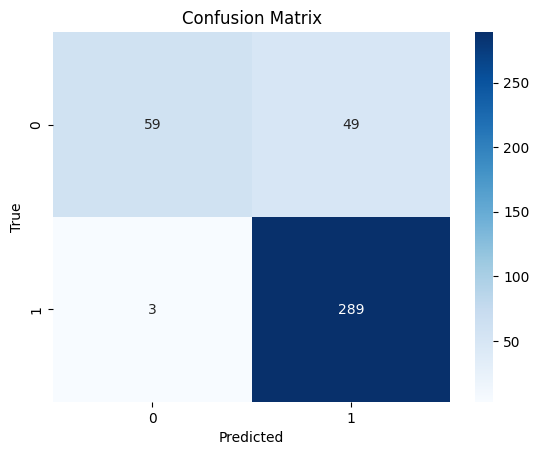

In [ ]:

print(classification_report(gts, preds, digits=3))
cm = confusion_matrix(gts, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## 9. 簡易アブレーション（各モダリティの寄与）

In [ ]:

@torch.no_grad()
def eval_with_mask(mask_img=True, mask_txt=True, mask_tab=True):
  preds, gts = [], []
  for img, txt, tab, y in val_loader:
    img, txt, tab = img.to(device), txt.to(device), tab.to(device)
    if mask_img:
      img = torch.zeros_like(img)
    if mask_txt:
      txt = torch.zeros_like(txt)
    if mask_tab:
      tab = torch.zeros_like(tab)
    logits = model(img, txt, tab)
    pred = torch.argmax(logits, dim=1).cpu().numpy()
    preds.extend(pred.tolist())
    gts.extend(y.numpy().tolist())
  acc = (np.array(preds) == np.array(gts)).mean()
  return acc

print('Acc (all):', eval_with_mask(False, False, False))
print('Acc (no image):', eval_with_mask(True, False, False))
print('Acc (no text):', eval_with_mask(False, True, False))
print('Acc (no tabular):', eval_with_mask(False, False, True))


Acc (all): 0.87
Acc (no image): 0.865
Acc (no text): 0.73
Acc (no tabular): 0.8025


## 10. 成果物の保存

In [ ]:

os.makedirs('artifacts', exist_ok=True)
torch.save(model.state_dict(), 'artifacts/mm_model.pt')
df.to_csv('artifacts/dummy_marketing_data.csv', index=False)
print('Saved to artifacts/.')


Saved to artifacts/.


## 11. SHAP とは（要約）
**SHAP**（SHapley Additive exPlanations）は、各特徴量が予測に与える**寄与度**を、ゲーム理論に基づく **Shapley 値**で近似する枠組みです。ここでは、
- モデルは **PyTorch の深層学習（マルチモーダル）**
- 対象は **表形式特徴（price / rating / discount）**
- 手法は **KernelExplainer**（モデル非依存、汎用）
を用います。画像とテキストは**ゼロベクトルで固定**し、表特徴の変動に対する**出力確率（buy=1）**の感度を SHAP で評価します。


In [ ]:

import shap
model.eval()

feature_names = ['price','rating','discount']

# Prediction function for SHAP: takes only tabular X (numpy) and returns class probabilities

def predict_tab(X_tab_np):
  with torch.no_grad():
    tab = torch.tensor(X_tab_np, dtype=torch.float32).to(device)
    # Fix image and text to zeros so we isolate tabular contribution
    img = torch.zeros((len(tab), 3, IMG_SIZE, IMG_SIZE), dtype=torch.float32).to(device)
    txt = torch.zeros((len(tab), VOCAB_SIZE), dtype=torch.float32).to(device)
    logits = model(img, txt, tab)
    probs = F.softmax(logits, dim=1).cpu().numpy()
    return probs  # shape (n, 2)

# Background (reference) samples for KernelExplainer
bg = train_df.sample(n=min(200, len(train_df)), random_state=42)[feature_names].to_numpy()
explainer = shap.KernelExplainer(predict_tab, bg, link='identity')

# Evaluation set
X_eval = val_df.sample(n=min(300, len(val_df)), random_state=0)[feature_names].to_numpy()
# Compute SHAP values (may take a few minutes depending on nsamples)
shap_values = explainer.shap_values(X_eval, nsamples=512)

# We focus on class 1 (buy=1)
# Original: shap_vals_class1 = shap_values[1]
# Fix: Assuming shap_values is (num_samples, num_features, num_classes)
# we need to slice for class 1 across all samples and features.
shap_vals_class1 = shap_values[:, :, 1]
print('SHAP values shape (class 1):', shap_vals_class1.shape)

  0%|          | 0/300 [00:00<?, ?it/s]

SHAP values shape (class 1): (300, 3)


## 12. SHAP 可視化（要約バー／散布）
- **バー**：平均絶対 SHAP 値による特徴重要度
- **散布**：各サンプルの SHAP 値と特徴値の関係


/tmp/ipython-input-1749287414.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals_class1, X_eval, feature_names=feature_names, plot_type='bar')


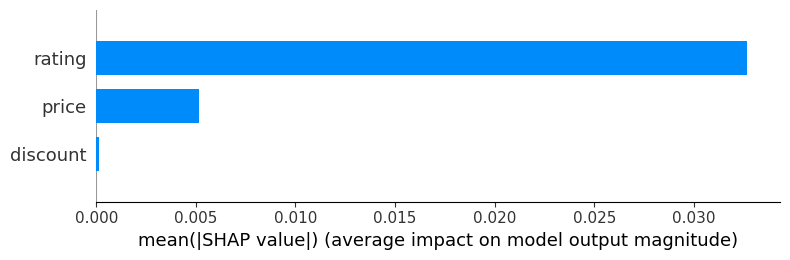

/tmp/ipython-input-1749287414.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals_class1, X_eval, feature_names=feature_names)


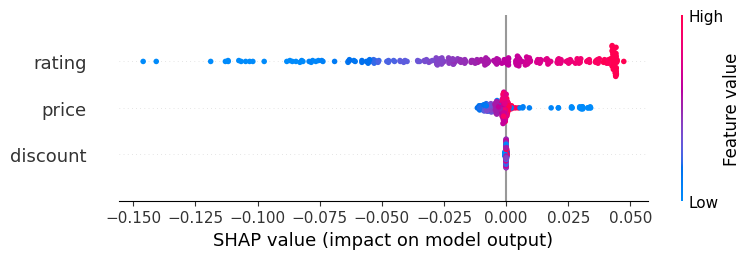

In [ ]:

# Summary bar plot (feature importance)
shap.summary_plot(shap_vals_class1, X_eval, feature_names=feature_names, plot_type='bar')

# Standard summary plot (beeswarm)
shap.summary_plot(shap_vals_class1, X_eval, feature_names=feature_names)

## 13. 数値出力と保存
平均絶対 SHAP 値を表形式で出力し、成果物として保存します。


In [ ]:

mean_abs = np.mean(np.abs(shap_vals_class1), axis=0)
imp_df = pd.DataFrame({'feature': feature_names, 'mean_abs_SHAP': mean_abs}).sort_values('mean_abs_SHAP', ascending=False)
print(imp_df)

os.makedirs('artifacts', exist_ok=True)
np.save('artifacts/shap_values_class1.npy', shap_vals_class1)
imp_df.to_csv('artifacts/shap_feature_importance.csv', index=False)
print('Saved SHAP artifacts to artifacts/.')


    feature  mean_abs_SHAP
1    rating       0.032681
0     price       0.005160
2  discount       0.000118
Saved SHAP artifacts to artifacts/.
